In [2]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [3]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [72]:
edge_N, bin_N = load_histo("../Dati/12_APR/Run_chall_ChargeHistos_4_12_2024_10M.dat")

channel = 5

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

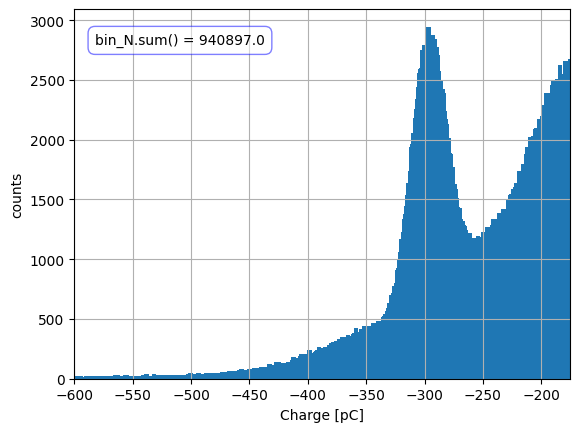

In [73]:
lim_list = [[-600, -165],  #ch0
            [-1, -1],  #ch1
            [-600, -175],  #ch2
            [-600, -145],  #ch3
            [-500, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-1, -1],  #ch12
            [-1, -1],  #ch13
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [74]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [75]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide



 
params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   #Indovina i parametri della prima gaussiana
#params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt = -15))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

model = exp1 + gauss1 + sigmoid1 + sigmoid2  #Per or

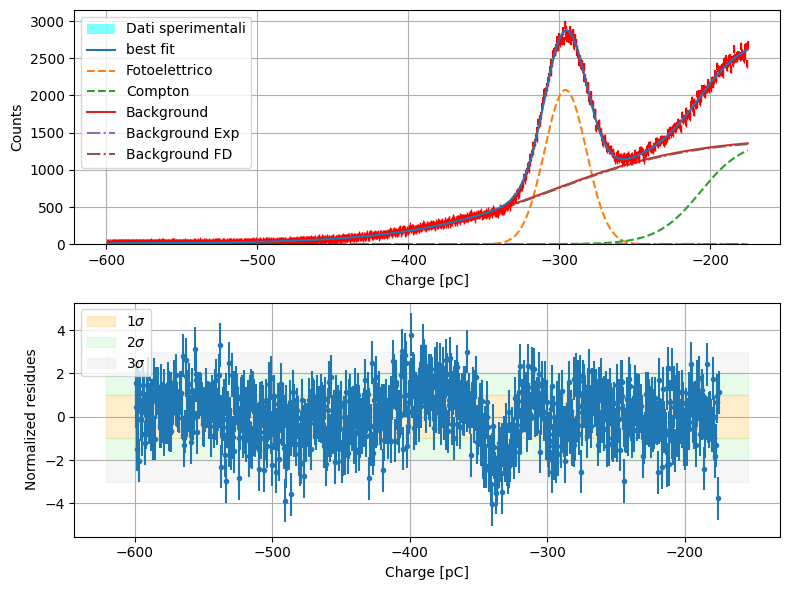

In [78]:
import pickle

params["s1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["s2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["s2_center"].vary = True
params["s2_sigma"].vary = True
params["g1_amplitude"].vary = True
params["g1_center"].vary = True
params["g1_sigma"].vary = True


#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
#params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False

params["s1_amplitude"].value = 10

params["g1_amplitude"].value = 425000    #Parametri da aggiustare to make the magic happen
params["g1_center"].min = -350          #Si possono, se serve, specificare canale per canale
params["g1_center"].max = -300
params["g1_center"].set(value = -325)
params["g1_sigma"].set(value = 15)

params["s2_amplitude"].set(value = 5000)
params["s2_center"].set(value = -230)
params["s2_sigma"].set(value = 5)
params["s2_center"].min = -350
params["s2_center"].max = -150

params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0



params.update(params)

with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

noise_params = noise_params[channel]

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)

params["s1_sigma"].vary = True   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = True  #lasciando libere le ampiezze
params["e1_decay"].vary = True
params["ratio"].vary = True
params["e1_amplitude"].vary = True
params["s1_amplitude"].vary = True
params["ratio"].vary = True
params["ratio"].expr = ""

params["s1_amplitude"].vary = True
params["e1_amplitude"].vary = True
params["e1_amplitude"].value = 54057.2496
params["e1_amplitude"].expr = "ratio * s1_amplitude"


# Fit the model to the data

if channel == 4:

    params["g1_center"].max = -270
    params["g1_center"].value = -280
    params["g1_amplitude"].value = 63000
    params["g1_sigma"].value = 12

    params["s2_center"].value = -205
    params["s2_amplitude"].value = 30
    params["s2_sigma"].value = 8.6

    params["ratio"].value = 8.5

    params["e1_amplitude"].value = 17000
    params["s1_amplitude"].value = 2000
    

    #s1_amplitude:  1941.90110 (init = 319.7595)
    #s1_center:    -283.529829 (init = -390.1003)
    #s1_sigma:      51.7666219 (init = 20.96735)

    #s2_amplitude:  946.147174 (init = 5000)
    #s2_center:    -205.163212 (init = -230)
    #s2_sigma:      8.68834922 (init = 5)

if channel == 5:
    params["g1_center"].max = -250


    

params.update(params)


result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [77]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24000
    # data points      = 817
    # variables        = 11
    chi-square         = 5291.46857
    reduced chi-square = 6.56509748
    Akaike info crit   = 1548.32921
    Bayesian info crit = 1600.09124
    R-squared          = 0.99999181
##  Warning: uncertainties could not be estimated:
    g1_center:     at boundary
[[Variables]]
    e1_amplitude:  41.7178267 == 'ratio * s1_amplitude'
    e1_decay:     -390.349804 (init = -88.68391)
    s1_amplitude:  1796.06966 (init = 322.39)
    s1_center:    -288.178244 (init = -391.6172)
    s1_sigma:      47.9479503 (init = 21.71882)
    g1_amplitude:  64919.6528 (init = 425000)
    g1_center:    -300.000000 (init = -325)
    g1_sigma:      13.1307377 (init = 15)
    g1_fwhm:       30.9205238